# Laboratorio 5
## Universidad del Valle de Guatemala <br> Facultas de Ingeniería
#### Departamento de Ciencias de la Computación <br> Deep Learning y Sistemas Inteligentes - Sección 20 <br> Jeyner Arango 201106 <br> Cristian Laynez 201281

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, UpSampling2D, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, _), (_, _) = mnist.load_data()

X_train = X_train[:10000]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [3]:
noise_dim = 50

In [4]:
generator = Sequential([
    Dense(64 * 7 * 7, input_dim=noise_dim),
    Reshape((7, 7, 64)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(32, (5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(1, (5, 5), padding='same', activation='tanh')
])

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              159936    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 64)          256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        5

### Red Generadora G(x)
1. Capa Dense: Esta capa toma una entrada de ruido aleatorio de dimension 50 y la proyecta en un espacio más grande.

2. Capa Reshape: Cambia la forma de la salida de la capa densa en un tensor 4D que se parece a una imagen con un tamaño de 7x7 y 64 canales.

3. Batch Normalization: La normalización por lotes ayuda a estabilizar y acelerar el entrenamiento ajustando la distribución de activaciones en cada lote.

4. Capa LeakyReLU: La activación LeakyReLU introduce una pequeña pendiente en la función de activación para evitar que los gradientes desaparezcan durante el entrenamiento.

5. Capa UpSampling2D: Esta capa aumenta el tamaño de la imagen interpolando entre píxeles para convertir una imagen de 7x7 en una de 14x14.

6. Capa Conv2D: Esta capa aplica una convolución a la imagen para aprender características específicas.

7. Batch Normalization: Lo mismo que el punto 3

8. Capa LeakyReLU: Lo mismo que el punto 4

9. Capa UpSampling2D: Lo mismo que la capa 5.

10. Capa Conv2D: Esta capa produce la salida final, que se espera que sea una imagen falsa generada por el generador.

In [5]:
discriminator = Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [6]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

In [7]:
discriminator.trainable = False

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

In [8]:
gan_input = Input(shape=(noise_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

### Red Discriminadora D(x)
El discriminador es una red neuronal convolucional secuencial que consta de varias capas:

1. Capa Conv2D: Una capa de convolución con 32 filtros de tamaño 5x5 el kernel, aplicando un paso de desplazamiento en horizontal y vertical de 2 y relleno 'same' para mantener el tamaño de la entrada. La entrada es una imagen de 28x28 píxeles en escala de gris de 1 dimensión tal como la red generadora entrega también su resultados.

2. Capa Leaky Relu : Con un valor de alfa de 0.01 para introducir una ligera pendiente en la función de activación y evitar gradientes que desaparezcan.

3. Capa dropout: Con una tasa del 30% para regularizar y evitar el sobreajuste

4. Capa Conv2D: Otra de convolución solo que con 64 filtros y mismos parámetros que la primera capa.

5. Capa Leaky Relu: Igual a la 2 con el mismo valor alpha.

6. Capa dropout: Ahora al igual que la 3 pero con una tasa de 20% para evitar sobreajuste

7. Capa Flatten: Convertierte la salida de las capas convolucionales en un vector unidimensional.

8. Capa Dense (fully connected): Con una sola unidad y función de activación sigmoidal. Esta capa produce una salida que se interpreta como la probabilidad de que la entrada sea una imagen real (1) o falsa generada por el generador (0) en el contexto de una GAN.

In [13]:
generator_inicial = Sequential([
    Dense(64 * 7 * 7, input_dim=noise_dim),
    Reshape((7, 7, 64)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(32, (5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(1, (5, 5), padding='same', activation='tanh')
])

In [14]:
generated_images_begin = generator_inicial.predict(noise)

1/1 [==============================] - 1s 689ms/step


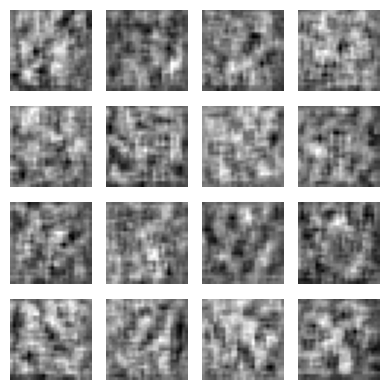

In [15]:
plt.figure(figsize=(4, 4))
for i in range(generated_images_begin.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images_begin[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
def train_gan(epochs=1, batch_size=64):
    batch_count = X_train.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Etiquetas suavizadas

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f'Época {e}:\tD Loss: {d_loss[0]} | Accuracy: {100 * d_loss[1]}%\tG Loss: {g_loss}')

In [10]:
train_gan(epochs=50, batch_size=64)

2/2 [==============================] - 0s 15ms/step
Época 0:	D Loss: 0.388584703207016 | Accuracy: 50.0%	G Loss: 0.449784517288208
2/2 [==============================] - 0s 13ms/step
Época 1:	D Loss: 0.5968917608261108 | Accuracy: 39.0625%	G Loss: 0.9229283332824707
2/2 [==============================] - 0s 18ms/step
Época 2:	D Loss: 0.6423298120498657 | Accuracy: 42.1875%	G Loss: 0.9428537487983704
2/2 [==============================] - 0s 12ms/step
Época 3:	D Loss: 0.7093278169631958 | Accuracy: 37.5%	G Loss: 0.7337457537651062
2/2 [==============================] - 0s 12ms/step
Época 4:	D Loss: 0.6697454452514648 | Accuracy: 46.875%	G Loss: 0.8288956880569458
2/2 [==============================] - 0s 11ms/step
Época 5:	D Loss: 0.6685311794281006 | Accuracy: 46.09375%	G Loss: 0.8670210838317871
2/2 [==============================] - 0s 14ms/step
Época 6:	D Loss: 0.6620769500732422 | Accuracy: 39.0625%	G Loss: 0.8072283267974854
2/2 [==============================] - 0s 12ms/step
Époc

In [12]:
noise = np.random.normal(0, 1, size=[16, noise_dim])
generated_images = generator.predict(noise)

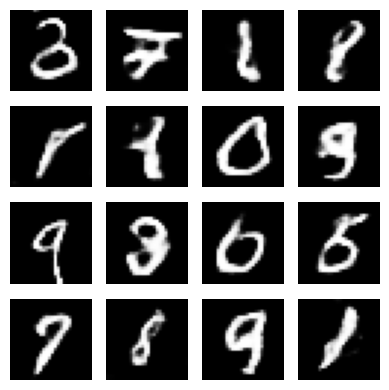

In [12]:
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()